In [9]:
import torch
import torch.nn as nn
import torchvision
from torchvision import transforms, datasets
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report, roc_auc_score
import pandas as pd

from torch.utils.data import Dataset, DataLoader
from PIL import Image

ROOT_DIR = '/gscratch/ubicomp/hughsun/HAM10000/ResNet'
TRAIN_PERC = 0.7 # training set size
VAL_PERC = 0.15 # validation set size
TEST_PERC = 0.15 # test set size

In [10]:
class SkinDataset(Dataset):
    '''
    create a dataset of skin images from the passed in metadata dataframe,
    and using the passed in transform.
    '''
    def __init__(self, df_metadata, transform):
        self.metadata = df_metadata
        self.transform = transform
        self.classes = ['mel', 'nv', 'bcc', 'akiec', 'bkl', 'df', 'vasc']
        self.class_to_idx = {'mel': 0, 'nv': 1, 'bcc': 2, 'akiec': 3, 'bkl': 4, 'df': 5, 'vasc': 6}
        
    def __len__(self):
        return len(self.metadata)

    def __getitem__(self, idx):
        img = self.read_image(idx)
        tensor_img = self.transform(img)
        age = self.metadata.iloc[idx]['age']
        sex = self.metadata.iloc[idx]['sex']
        dx = self.metadata.iloc[idx]['dx']
        dx = self.class_to_idx[dx]
        return (tensor_img, age, sex, dx)
        
    def read_image(self, idx):
        image_file_name = self.metadata.iloc[idx]['image_id']
        return Image.open(f'{ROOT_DIR}/HAM10000/{image_file_name}.jpg')

In [20]:
def evaluate_given_loader(loader):
    '''
    Given a dataloader, print out relevant metrics
    and plots by evaluating based on the data from
    this dataloader.
    '''
    num_classes = 7

    predlist = torch.zeros(0,dtype=torch.long, device='cpu')
    lbllist = torch.zeros(0,dtype=torch.long, device='cpu')
    predlistauc = torch.zeros(0,dtype=torch.long, device='cpu')

    model.eval()

    with torch.no_grad():
        for i, (inputs, _, _, classes) in enumerate(loader):        
            inputs = inputs.to(device)
            classes = classes.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            # Append batch prediction results
            predlist=torch.cat([predlist,preds.view(-1).cpu()])
            lbllist=torch.cat([lbllist,classes.view(-1).cpu()])
            predlistauc = torch.cat([predlistauc,nn.functional.softmax(outputs, dim=1).cpu()])
    predlist = predlist.numpy()
    lbllist = lbllist.numpy()
    predlistauc = predlistauc.numpy()

    conf_mat=confusion_matrix(lbllist, predlist)

    target_names = ['MEL','NV','BCC','AKIEC','BKL','DF','VASC',]

    ConfusionMatrixDisplay(conf_mat, display_labels=target_names).plot(values_format="d")

    print(classification_report(lbllist, predlist, target_names=target_names))

    lbllist_one_hot = nn.functional.one_hot(torch.tensor([lbllist]), num_classes=num_classes)
    every_auc = roc_auc_score(lbllist_one_hot.view([predlistauc.shape[0], predlistauc.shape[1]]), 
                                              predlistauc, multi_class='ovr', average=None)
    for i, every in enumerate(target_names):
        print(f'AUC of class {every} = {every_auc[i]}')

In [26]:
def evaluate_model_given_seed(seed):
    '''
    print out relevant metrics and confusion matrix
    for a given model trained with a specific seed number.
    Will print overall performance on validation and test set,
    and print different test set metrics for different gender and age.
    '''
    device = 'cuda'
    model = torchvision.models.resnet50(pretrained=True).to(device)
    model.fc = nn.Linear(2048, 7).to(device)
    model.load_state_dict(torch.load(f'{ROOT_DIR}/skin_models/skinmodel50_{seed}.pt'))
    
    val_transforms = transforms.Compose([
        transforms.Resize((224, 280)),
        torchvision.transforms.CenterCrop((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        ])

    metadata = pd.read_csv(f'{ROOT_DIR}/HAM10000_metadata.csv')

    data_size = len(metadata)
    train_size = int(data_size * TRAIN_PERC)
    val_size = int(data_size * VAL_PERC)
    test_size = data_size - train_size - val_size

    shuffled_metadata = metadata.sample(frac = 1, random_state = seed)
    # train_metadata = shuffled_metadata[:train_size]
    val_metadata = shuffled_metadata[train_size: train_size + val_size]
    test_metadata = shuffled_metadata[train_size + val_size: train_size + val_size + test_size]

    # train_dataset = SkinDataset(train_metadata, train_transforms)
    val_dataset = SkinDataset(val_metadata, val_transforms)
    test_dataset = SkinDataset(test_metadata, val_transforms)

    val_loader = DataLoader(
        val_dataset, batch_size=64, shuffle=False,
        pin_memory=True, drop_last=False)

    test_loader = DataLoader(
        test_dataset, batch_size=64, shuffle=False,
        pin_memory=True, drop_last=False)
    
    print('for validation set, overall:')
    evaluate_given_loader(val_loader)
    print('------------------')
    print('for test set, overall:')
    evaluate_given_loader(test_loader)
    print('------------------')
    
    def evaluate_given_df(metadata, transforms):
        '''
        evaluate model given a metadata dataframe + transforms
        '''
        dataset = SkinDataset(metadata, transforms)
        dataloader = DataLoader(
            dataset, batch_size=64, shuffle=False,
            pin_memory=True, drop_last=False)
        evaluate_given_loader(dataloader)
    
    print('for test set, male:')
    test_metadata_male = test_metadata[test_metadata['sex'] == 'male']
    evaluate_given_df(test_metadata_male, val_transforms)
    print('------------------')
    
    print('for test set, female:')
    test_metadata_female = test_metadata[test_metadata['sex'] == 'female']
    evaluate_given_df(test_metadata_female, val_transforms)
    print('------------------')
    
    print('for test set, old (age >= 45):')
    test_metadata_old = test_metadata[test_metadata['age'] >= 45]
    evaluate_given_df(test_metadata_old, val_transforms)
    print('------------------')
    
    print('for test set, young (age < 45):')
    test_metadata_young = test_metadata[test_metadata['age'] < 45]
    evaluate_given_df(test_metadata_young, val_transforms)
    print('------------------')

for validation set, overall:
              precision    recall  f1-score   support

         MEL       0.57      0.36      0.44       152
          NV       0.88      0.95      0.91      1025
         BCC       0.70      0.74      0.72        81
       AKIEC       0.43      0.42      0.43        45
         BKL       0.64      0.61      0.63       161
          DF       0.90      0.56      0.69        16
        VASC       1.00      0.50      0.67        22

    accuracy                           0.81      1502
   macro avg       0.73      0.59      0.64      1502
weighted avg       0.80      0.81      0.80      1502

AUC of class MEL = 0.9160038986354777
AUC of class NV = 0.9501314107480696
AUC of class BCC = 0.9806778394627328
AUC of class AKIEC = 0.9500190650499505
AUC of class BKL = 0.9363180346547724
AUC of class DF = 0.932999663526245
AUC of class VASC = 0.985933660933661
------------------
for test set, overall:
              precision    recall  f1-score   support

         MEL

/gscratch/ubicomp/hughsun/conda/HAM10000_resnet/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/gscratch/ubicomp/hughsun/conda/HAM10000_resnet/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/gscratch/ubicomp/hughsun/conda/HAM10000_resnet/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average

ValueError: Only one class present in y_true. ROC AUC score is not defined in that case.

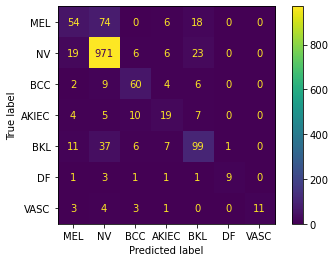

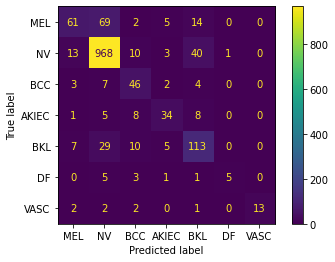

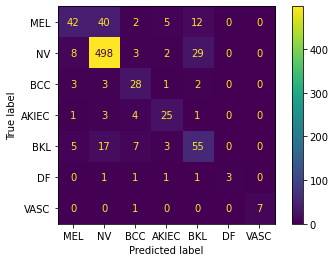

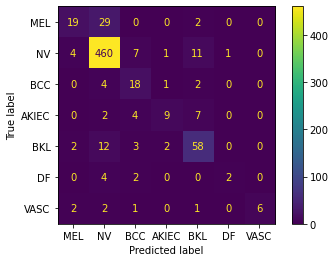

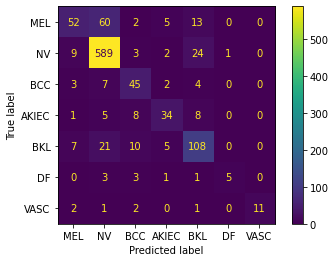

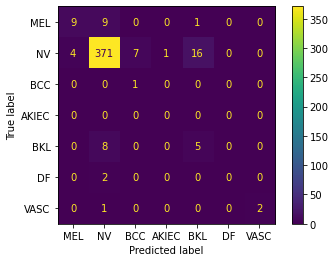

In [27]:
evaluate_model_given_seed(446)